Transfer Learning with MobileNetV3

<a name='1'></a>
# Packages

In [2]:
import keras.layers as tfl
import plotly.express as px
import tensorflow as tf
from keras_flops import get_flops

from train_utils.models import PercentageModel

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [59]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

NUM_CLASSES_OBJECTS = 133
NUM_CLASSES_CATEGORIES = 9

OBJECT_LABELS = open('models/objects/label_names.txt', 'r').read().split('\n')
CATEGORY_LABELS = open('models/categories/label_names.txt', 'r').read().split('\n')

# Define Hybrid Model

## Object Components

In [26]:
def mobilenet_large_model():
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='models/objects/mobilenet_weights.h5',
        dropout_rate=0.3,
        pooling='avg',)
    model.trainable = False
    return model


def object_top_model(input_shape=(960,)):
    inputs = tf.keras.Input(
        name='Input',
        shape=input_shape,)
    x = inputs
    
    x = tfl.Dense(
        units=NUM_CLASSES_OBJECTS,
        name='DenseObject',
        activation='sigmoid',)(x)
    
    outputs = x
    model = tf.keras.Model(
        inputs,
        outputs,
        name='TopObject')
    
    model.load_weights('models/objects/top_weights.h5')
    model.trainable = False
    
    return model

## Category Components

In [27]:
def mobilenet_small_model():
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='models/categories/mobilenet_weights.h5',
        alpha=0.15,
        pooling='avg',)
    model.trainable = False
    return model

def category_top_model(input_shape=(1056,)):
    inputs = tf.keras.Input(
        name='Input',
        shape=input_shape,)
    x = inputs
    
    x = tfl.Dense(
        units=NUM_CLASSES_CATEGORIES,
        name='DenseCategory',
        activation='softmax',)(x)
    
    outputs = x
    model = tf.keras.Model(
        inputs,
        outputs,
        name='TopCategory')
    
    model.load_weights('models/categories/top_weights.h5')
    model.trainable = False
    
    return model

## Hybrid Model

In [106]:
def hybrid_model():
    mobilenet_large = mobilenet_large_model()
    mobilenet_small = mobilenet_small_model()
    category_top = category_top_model()
    object_top = object_top_model()
    
    inputs = tf.keras.Input(
        name='Input',
        shape=IMG_SHAPE)
    
    x = inputs
    xl, xs = mobilenet_large(x), mobilenet_small(x)
    
    categories, objects = category_top(tf.concat((xs, xl), axis=-1)), object_top(xl)
    
    outputs = tf.concat((categories, objects), axis=-1)
    model = PercentageModel(
                inputs,
                outputs,
                name='full',)
    return model

In [107]:
model = hybrid_model()
print(model.summary())

print('Total Flops:', get_flops(model, batch_size=1) // 2)

Model: "full"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 96)           45336       ['Input[0][0]']                  
                                                                                                  
 MobilenetV3large (Functional)  (None, 960)          2996352     ['Input[0][0]']                  
                                                                                                  
 tf.concat_3 (TFOpLambda)       (None, 1056)         0           ['MobilenetV3small[0][0]',    

## Extended Training

# Test Model Predictions

In [49]:
from PIL import Image
from tools.square_crop import crop_to_aspect

In [91]:
OBJECT_THRESHOLD = 0.555
CATEGORY_THRESHOLD = 0.5

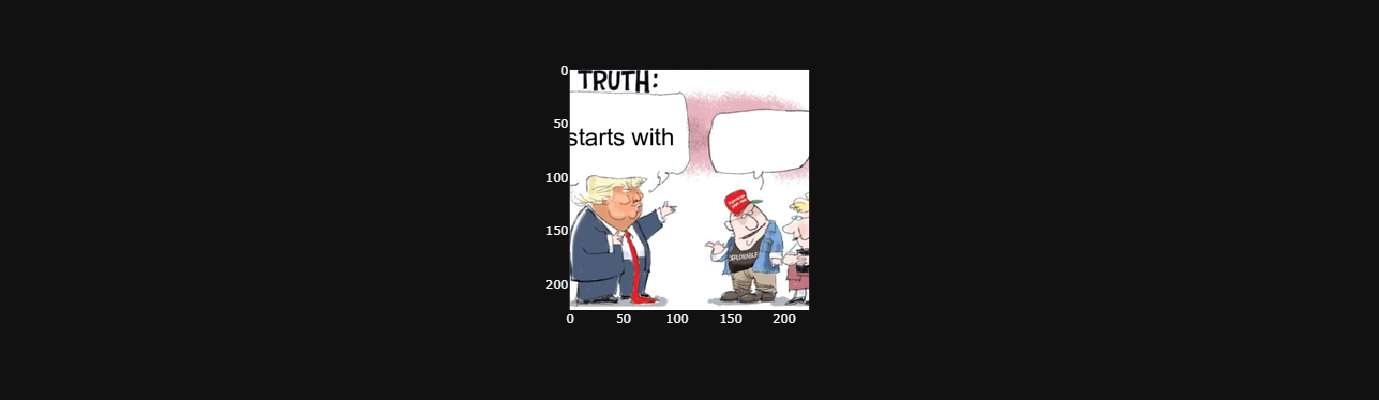

category =  ('memes', 0.98467666)
objects =  [('person', 0.84741193)]


In [110]:
img = Image.open(r"C:\Users\arlak\Downloads\Screenshot 2022-06-17 015554.png")
img = crop_to_aspect(img, 1).resize((224, 224), Image.Resampling.LANCZOS).convert('RGB')

fig = px.imshow(img)
fig.update_layout(
    template='plotly_dark', 
    height=400, width=400,)
fig.show()

inp = tf.constant(img)

output = model(inp[None, ...])[0]
categories_p, objects_p = output[:NUM_CLASSES_CATEGORIES], output[NUM_CLASSES_CATEGORIES:]

category = ("other", 1.0)
for i, p in enumerate(categories_p.numpy()):
    if p >= CATEGORY_THRESHOLD:
        category = (CATEGORY_LABELS[i], p)
print('category = ', category)
        
objects = []
for i, p in enumerate(objects_p.numpy()):
    if p >= OBJECT_THRESHOLD:
        objects += [(OBJECT_LABELS[i], p)]
print('objects = ', objects)

# Save the model

In [111]:
_saved_model_dir = 'models\\hybrid\\hybrid_model'

model.save('models\\hybrid\\hybrid.h5')
model.save_weights('models\\hybrid\\hybrid_weights.h5')
tf.saved_model.save(model, _saved_model_dir)

INFO:tensorflow:Assets written to: models\hybrid\hybrid_model\assets


INFO:tensorflow:Assets written to: models\hybrid\hybrid_model\assets


# Generate The TFLite Model

In [113]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(_saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('models/hybrid/hybrid.tflite', 'wb') as f:
    f.write(tflite_model)

In [2]:
from tflite_support.metadata_writers import image_classifier, writer_utils

In [5]:
writer = object_detector.MetadataWriter
_MODEL_PATH = "models/objects/ssd_mobilenet_v2_uint8.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "models/objects/ssd_mobilenet_v2_uint8.txt"
_SAVE_TO_PATH = "models/objects/ssd_mobilenet_v2_uint8_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = writer.create_for_inference(
    writer_utils.load_file(_MODEL_PATH),
    [_INPUT_NORM_MEAN], 
    [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

KeyError: 298